In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import albumentations as albu
from tqdm.notebook import tqdm

In [2]:
class CFG:
    img_size = 256
    nof_epochs = 10 
    

# Functions

In [3]:

def group_boxes(group):
    boundaries = group['bbox'].str.split(',', expand=True)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

In [4]:

def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')
    
def draw_bboxes(image_id, bboxes, source='train'):  
    image = Image.open('../input/global-wheat-detection/' + source +'/' + image_id + ".jpg")
    image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)


def show_images(image_ids, bboxes, source='train'):
    pixels = []
    
    for image_id in image_ids:
        pixels.append(
            draw_bboxes(image_id, bboxes[image_id], source)
        )
    
    num_of_images = len(image_ids)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * num_of_images, 5 * num_of_images)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[i].imshow(image_pixels)

In [5]:
def load_image(image_id):
    image = Image.open('../input/global-wheat-detection/train/' + image_id + ".jpg")
    image = image.resize((CFG.img_size, CFG.img_size))
    
    return np.asarray(image)

In [6]:
def create_model():
    
    x_input = tf.keras.Input(shape=(CFG.img_size,CFG.img_size,3))

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    ########## block 1 ##########
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x_shortcut = x


    ########## block 2 ##########
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x_shortcut = x

    ########## block 3 ##########
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    for i in range(8):
        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x_shortcut = x


    ########## block 4 ##########
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    for i in range(8):
        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x_shortcut = x

    ########## block 5 ##########
    x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x_shortcut = x

    for i in range(4):
        x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Conv2D(1024, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

        x_shortcut = x

    ########## output layers ##########
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)

    predictions = tf.keras.layers.Conv2D(10, (1, 1), strides=(1, 1), activation='sigmoid')(x)

    model = tf.keras.Model(inputs=x_input, outputs=predictions)
    
    
    return model

# Data


In [7]:
labels = pd.read_csv('../input/global-wheat-detection/train.csv')
labels.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [8]:
labels.source.value_counts()

ethz_1       51489
arvalis_1    45716
rres_1       20236
arvalis_3    16665
usask_1       5807
arvalis_2     4179
inrae_1       3701
Name: source, dtype: int64

The competition page stated the following: "You will use more than 3,000 images from Europe (France, UK, Switzerland) and North America (Canada). The test data includes about 1,000 images from Australia, Japan, and China". This means using a random split for training / validation would introduce leakage, so we need to split on area of origin - the ``source`` column. We will use Switzerland as a holdout region.

In [9]:
labels_train = labels.loc[labels.source != 'ethz_1'].copy()
labels_valid = labels.loc[labels.source != 'ethz_1'].copy()


In [10]:
labels_train = labels_train.groupby('image_id').apply(group_boxes)
labels_train.head()

image_id
00333207f    [[0.0, 654.0, 37.0, 111.0], [0.0, 817.0, 135.0...
005b0d8bb    [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
006a994f7    [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
00764ad5d    [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
00b5fefed    [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
dtype: object

In [11]:
labels_valid = labels_valid.groupby('image_id').apply(group_boxes)
labels_valid.head()

image_id
00333207f    [[0.0, 654.0, 37.0, 111.0], [0.0, 817.0, 135.0...
005b0d8bb    [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
006a994f7    [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
00764ad5d    [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
00b5fefed    [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
dtype: object

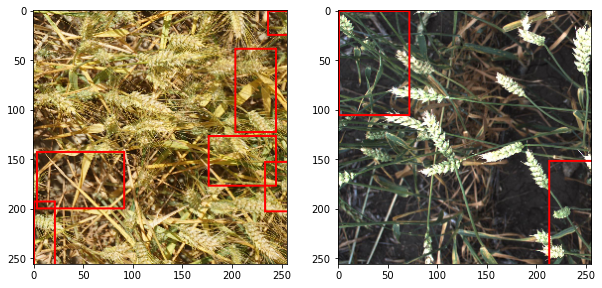

In [12]:
show_images(labels_train.index[0:2], labels_train)

In [13]:
train_image_ids = labels_train.index.values
val_image_ids = labels_valid.index.values

In [14]:
train_pixels = {}
train_labels = {}

for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels_train[image_id].copy() / 4

In [15]:
val_pixels = {}
val_labels = {}

for image_id in tqdm(val_image_ids):
    val_pixels[image_id] = load_image(image_id)    
    val_labels[image_id] = labels_valid[image_id].copy() / 4

<!-- ## Clean bounding boxes

There are a small number of bounding boxes in this dataset that do not bound a head of wheat. While the number is small enough that the model can still learn how to detect the heads of wheat they still cause a little bit of inaccuracy. Below I'll search for tiny bounding boxes that cannot possibly fit a head of wheat inside them and huge bounding boxes that miss the head of wheat they are aimed at. -->

# Pipeline


In [16]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, image_ids, image_pixels, labels=None, batch_size=1, shuffle=False, augment=False):
        self.image_ids = image_ids
        self.image_pixels = image_pixels
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.image_grid = self.form_image_grid()
        
        
    def form_image_grid(self):    
        image_grid = np.zeros((32, 32, 4))

        # x, y, width, height
        cell = [0, 0, 256 / 32, 256 / 32] 

        for i in range(0, 32):
            for j in range(0, 32):
                image_grid[i,j] = cell

                cell[0] = cell[0] + cell[2]

            cell[0] = 0
            cell[1] = cell[1] + cell[3]

        return image_grid
    
def __len__(self):
    return int(np.floor(len(self.image_ids) / self.batch_size))


def on_epoch_end(self):
    self.indexes = np.arange(len(self.image_ids))

    if self.shuffle == True:
        np.random.shuffle(self.indexes)


DataGenerator.__len__ = __len__
DataGenerator.on_epoch_end = on_epoch_end

In [17]:
DataGenerator.train_augmentations = albu.Compose([
        albu.RandomSizedCrop(
            min_max_height=(200, 200), 
            height=256, 
            width=256, 
            p=0.8
        ),
        albu.OneOf([
            albu.Flip(),
            albu.RandomRotate90(),
        ], p=1),
        albu.OneOf([
            albu.HueSaturationValue(),
            albu.RandomBrightnessContrast()
        ], p=1),
        albu.OneOf([
            albu.GaussNoise(),
            albu.GlassBlur(),
            albu.ISONoise(),
            albu.MultiplicativeNoise(),
        ], p=0.5),
        albu.Cutout(
            num_holes=8, 
            max_h_size=16, 
            max_w_size=16, 
            fill_value=0, 
            p=0.5
        ),
        albu.CLAHE(p=1),
        albu.ToGray(p=1),
    ], 
    bbox_params={'format': 'coco', 'label_fields': ['labels']})

DataGenerator.val_augmentations = albu.Compose([
    albu.CLAHE(p=1),
    albu.ToGray(p=1),
])

In [18]:
def __getitem__(self, index):
    indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

    batch_ids = [self.image_ids[i] for i in indexes]

    X, y = self.__data_generation(batch_ids)

    return X, y


def __data_generation(self, batch_ids):
    X, y = [], []

    # Generate data
    for i, image_id in enumerate(batch_ids):
        pixels = self.image_pixels[image_id]
        bboxes = self.labels[image_id]

        if self.augment:     
            pixels, bboxes = self.augment_image(pixels, bboxes)
        else:
            pixels = self.contrast_image(pixels)
            bboxes = self.form_label_grid(bboxes)

        X.append(pixels)
        y.append(bboxes)

    return np.array(X), np.array(y)


def augment_image(self, pixels, bboxes):
    bbox_labels = np.ones(len(bboxes))

    aug_result = self.train_augmentations(image=pixels, bboxes=bboxes, labels=bbox_labels)

    bboxes = self.form_label_grid(aug_result['bboxes'])

    return np.array(aug_result['image']) / 255, bboxes


def contrast_image(self, pixels):        
    aug_result = self.val_augmentations(image=pixels)
    return np.array(aug_result['image']) / 255


DataGenerator.__getitem__ = __getitem__
DataGenerator.__data_generation = __data_generation
DataGenerator.augment_image = augment_image
DataGenerator.contrast_image = contrast_image

In [19]:
def form_label_grid(self, bboxes):
    label_grid = np.zeros((32, 32, 10))

    for i in range(0, 32):
        for j in range(0, 32):
            cell = self.image_grid[i,j]
            label_grid[i,j] = self.rect_intersect(cell, bboxes)

    return label_grid


def rect_intersect(self, cell, bboxes): 
    cell_x, cell_y, cell_width, cell_height = cell
    cell_x_max = cell_x + cell_width 
    cell_y_max = cell_y + cell_height
    
    anchor_one = np.array([0, 0, 0, 0, 0])
    anchor_two = np.array([0, 0, 0, 0, 0])

    # check all boxes
    for bbox in bboxes:
        box_x, box_y, box_width, box_height = bbox
        box_x_centre = box_x + (box_width / 2)
        box_y_centre = box_y + (box_height / 2)

        if(box_x_centre >= cell_x and box_x_centre < cell_x_max and box_y_centre >= cell_y and box_y_centre < cell_y_max):
            
            if anchor_one[0] == 0:
                anchor_one = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
            
            elif anchor_two[0] == 0:
                anchor_two = self.yolo_shape(
                    [box_x, box_y, box_width, box_height], 
                    [cell_x, cell_y, cell_width, cell_height]
                )
                
            else:
                break

    return np.concatenate((anchor_one, anchor_two), axis=None)


def yolo_shape(self, box, cell):
    box_x, box_y, box_width, box_height = box
    cell_x, cell_y, cell_width, cell_height = cell

    # top left x,y to centre x,y
    box_x = box_x + (box_width / 2)
    box_y = box_y + (box_height / 2)

    # offset bbox x,y to cell x,y
    box_x = (box_x - cell_x) / cell_width
    box_y = (box_y - cell_y) / cell_height

    # bbox width,height relative to cell width,height
    box_width = box_width / 256
    box_height = box_height / 256

    return [1, box_x, box_y, box_width, box_height]


DataGenerator.form_label_grid = form_label_grid
DataGenerator.rect_intersect = rect_intersect
DataGenerator.yolo_shape = yolo_shape

In [20]:
train_generator = DataGenerator(
    train_image_ids,
    train_pixels,
    train_labels, 
    batch_size=6, 
    shuffle=True,
    augment=True
)

val_generator = DataGenerator(
    val_image_ids, 
    val_pixels,
    val_labels, 
    batch_size=10,
    shuffle=False,
    augment=False
)

image_grid = train_generator.image_grid

# Model

With the data ready to go I'll define and train the model. As mentioned before this model is inspired by yolo, specifically yolo v3. This is a large and at times complex model. Below is an outline of the model. 

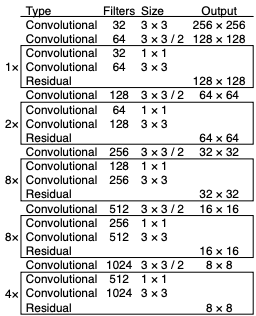
*figure 3, An outline of the model taken from the yolov3 [paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf).*

Below is my keras implementation of the model. The model is mostly in line with the yolov3 architecture though I have removed a few layers and altered some others. 

In [21]:
model = create_model()

In [22]:
def custom_loss(y_true, y_pred):
    binary_crossentropy = prob_loss = tf.keras.losses.BinaryCrossentropy(
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
    )
    
    prob_loss = binary_crossentropy(
        tf.concat([y_true[:,:,:,0], y_true[:,:,:,5]], axis=0), 
        tf.concat([y_pred[:,:,:,0], y_pred[:,:,:,5]], axis=0)
    )
    
    xy_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,1:3], y_true[:,:,:,6:8]], axis=0), 
        tf.concat([y_pred[:,:,:,1:3], y_pred[:,:,:,6:8]], axis=0)
    )
    
    wh_loss = tf.keras.losses.MSE(
        tf.concat([y_true[:,:,:,3:5], y_true[:,:,:,8:10]], axis=0), 
        tf.concat([y_pred[:,:,:,3:5], y_pred[:,:,:,8:10]], axis=0)
    )
    
    bboxes_mask = get_mask(y_true)
    
    xy_loss = xy_loss * bboxes_mask
    wh_loss = wh_loss * bboxes_mask
    
    return prob_loss + xy_loss + wh_loss


def get_mask(y_true):
    anchor_one_mask = tf.where(
        y_true[:,:,:,0] == 0, 
        0.5, 
        5.0
    )
    
    anchor_two_mask = tf.where(
        y_true[:,:,:,5] == 0, 
        0.5, 
        5.0
    )
    
    bboxes_mask = tf.concat(
        [anchor_one_mask,anchor_two_mask],
        axis=0
    )
    
    return bboxes_mask

In [23]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimiser, 
    loss=custom_loss
)

In [24]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True),
]

In [25]:
history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    epochs = CFG.nof_epochs,
    callbacks=callbacks
)

Train for 437 steps, validate for 262 steps
Epoch 1/10
437/437 [==============================] - 848s 2s/step - loss: 0.2797 - val_loss: 0.1540
Epoch 2/10
437/437 [==============================] - 838s 2s/step - loss: 0.1121 - val_loss: 0.1032
Epoch 3/10
437/437 [==============================] - 835s 2s/step - loss: 0.0770 - val_loss: 0.0892
Epoch 4/10
437/437 [==============================] - 839s 2s/step - loss: 0.0651 - val_loss: 0.0744
Epoch 5/10
437/437 [==============================] - 835s 2s/step - loss: 0.0591 - val_loss: 0.0695
Epoch 6/10
437/437 [==============================] - 839s 2s/step - loss: 0.0560 - val_loss: 0.0617
Epoch 7/10
437/437 [==============================] - 839s 2s/step - loss: 0.0536 - val_loss: 0.0589
Epoch 8/10
437/437 [==============================] - 839s 2s/step - loss: 0.0518 - val_loss: 0.0559
Epoch 9/10
437/437 [==============================] - 838s 2s/step - loss: 0.0503 - val_loss: 0.0564
Epoch 10/10
437/437 [==========================

In [26]:
print('Epochs: ' + str(len(history.history['loss'])))
print('Final training loss: ' + str( np.round(history.history['loss'][-1],4)  ))
print('Final validation loss: ' + str( np.round( history.history['val_loss'][-1], 4)  ))

Epochs: 10
Final training loss: 0.0495
Final validation loss: 0.0769


# Evaluation and submission


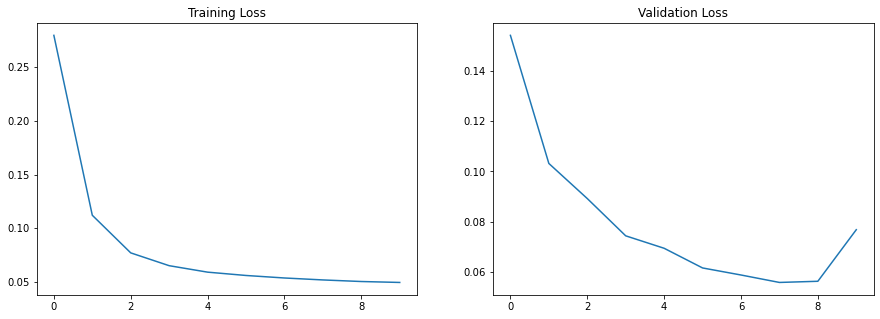

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Training Loss')
ax[0].plot(history.history['loss'])

ax[1].set_title('Validation Loss')
ax[1].plot(history.history['val_loss'])


The model outputs the predicted bounding boxes as a label grid. However to visualise the bounding boxes on an image or submit them to the competition the shape for one images bounding boxes need changing from (16,16,10) to (m, 4) where m represents the number of bounding boxes that have a high confidence.

This first function transforms the boxes from the yolo format to the coco format. It does this through the following:

- return the scale of the boxes from 0-1 to 0-256
- change the x,y from the centre of the box to the top left corner
- change width and height to x_max, y_max i.e. change to voc shape

In [28]:
def prediction_to_bbox(bboxes, image_grid):    
    bboxes = bboxes.copy()
    
    im_width = (image_grid[:,:,2] * 32)
    im_height = (image_grid[:,:,3] * 32)
    
    # descale x,y
    bboxes[:,:,1] = (bboxes[:,:,1] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,2] = (bboxes[:,:,2] * image_grid[:,:,3]) + image_grid[:,:,1]
    bboxes[:,:,6] = (bboxes[:,:,6] * image_grid[:,:,2]) + image_grid[:,:,0]
    bboxes[:,:,7] = (bboxes[:,:,7] * image_grid[:,:,3]) + image_grid[:,:,1]
    
    # descale width,height
    bboxes[:,:,3] = bboxes[:,:,3] * im_width 
    bboxes[:,:,4] = bboxes[:,:,4] * im_height
    bboxes[:,:,8] = bboxes[:,:,8] * im_width 
    bboxes[:,:,9] = bboxes[:,:,9] * im_height
    
    # centre x,y to top left x,y
    bboxes[:,:,1] = bboxes[:,:,1] - (bboxes[:,:,3] / 2)
    bboxes[:,:,2] = bboxes[:,:,2] - (bboxes[:,:,4] / 2)
    bboxes[:,:,6] = bboxes[:,:,6] - (bboxes[:,:,8] / 2)
    bboxes[:,:,7] = bboxes[:,:,7] - (bboxes[:,:,9] / 2)
    
    # width,heigth to x_max,y_max
    bboxes[:,:,3] = bboxes[:,:,1] + bboxes[:,:,3]
    bboxes[:,:,4] = bboxes[:,:,2] + bboxes[:,:,4]
    bboxes[:,:,8] = bboxes[:,:,6] + bboxes[:,:,8]
    bboxes[:,:,9] = bboxes[:,:,7] + bboxes[:,:,9]
    
    return bboxes

Next the bounding boxes with low confidence need removing. I also need to remove any boxes that overlap another box. Luckily Tensorflow has a non-max suppression function that filters out both low confidence boxes and removes one box if any two overlap. There's just a little bit of reshaping to prepare the bounding boxes for this function one of which includes switching the position of the x and y dimensions.

In [29]:
def non_max_suppression(predictions, top_n):
    probabilities = np.concatenate((predictions[:,:,0].flatten(), predictions[:,:,5].flatten()), axis=None)
    
    first_anchors = predictions[:,:,1:5].reshape((32*32, 4))
    second_anchors = predictions[:,:,6:10].reshape((32*32, 4))
    
    bboxes = np.concatenate(
        (first_anchors,second_anchors),
        axis=0
    )
    
    bboxes = switch_x_y(bboxes)
    bboxes, probabilities = select_top(probabilities, bboxes, top_n=top_n)
    bboxes = switch_x_y(bboxes)
    
    return bboxes


def switch_x_y(bboxes):
    x1 = bboxes[:,0].copy()
    y1 = bboxes[:,1].copy()
    x2 = bboxes[:,2].copy()
    y2 = bboxes[:,3].copy()
    
    bboxes[:,0] = y1
    bboxes[:,1] = x1
    bboxes[:,2] = y2
    bboxes[:,3] = x2
    
    return bboxes


def select_top(probabilities, boxes, top_n=10):
    top_indices = tf.image.non_max_suppression(
        boxes = boxes, 
        scores = probabilities, 
        max_output_size = top_n, 
        iou_threshold = 0.3,
        score_threshold = 0.3
    )
    
    top_indices = top_indices.numpy()
    
    return boxes[top_indices], probabilities[top_indices]

Wrap these post-processing functions into one and output the predicted bounding boxes as a dictionary where the image id is the key.

In [30]:
def process_predictions(predictions, image_ids, image_grid):
    bboxes = {}
    
    for i, image_id in enumerate(image_ids):
        predictions[i] = prediction_to_bbox(predictions[i], image_grid)
        bboxes[image_id] = non_max_suppression(predictions[i], top_n=100)
        
        # back to coco shape
        bboxes[image_id][:,2:4] = bboxes[image_id][:,2:4] - bboxes[image_id][:,0:2]
    
    return bboxes

Let's see how the model did by producing predictions for some images in the validation dataset.

In [31]:
val_predictions = model.predict(val_generator)
val_predictions = process_predictions(val_predictions, val_image_ids, image_grid)

IndexError: index 2620 is out of bounds for axis 0 with size 2620

In [ ]:
show_images(val_image_ids[0:4], val_predictions)